In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_stata('../../../HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [3]:
chosen_cols = [
    'time_from_met_to_rel',  # numeryczna - czas (w latach), który upłynął od poznania do wejścia w związek
    'time_from_rel_to_cohab', # numeryczna - czas (w latach), który upłynął od wejścia w związek do zamieszkania razem
    'Q25',  # jakościowa - czy uczęszczałeś z partnerem do tej samej szkoły średniej
    'Q12', # jakościowa - jak partner opisuje swoje poglądy polityczne
    'S1',  # output
]

df[chosen_cols].head()

,time_from_met_to_rel,time_from_rel_to_cohab,Q25,Q12,S1
0,0.000000,NaN,NaN,NaN,"No, I am not Married"
1,12.250000,0.500000,Different High School,Leans Republican,"Yes, I am Married"
2,0.416748,0.083252,Different High School,Leans Democrat,"Yes, I am Married"
3,1.083252,NaN,NaN,NaN,"No, I am not Married"
4,0.083252,0.833374,Different High School,Strong Democrat,"Yes, I am Married"


In [4]:
# kilka parametrów danych
print(df[chosen_cols].count())  # liczba niepustych wartości w każdej kolumnie 
print('=' * 30)
print('before drop:', len(df[chosen_cols]))
print('after drop:', len(df[chosen_cols].dropna()))  # liczba wierszy przed i po usunięciu niekompletnych wierszy

cleaner_df = df[chosen_cols].dropna()
cleaner_df['S1'] = cleaner_df['S1'].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
cleaner_df['S1'] = cleaner_df['S1'].astype('float')  # przekształcenie kolumny wynikowej do postaci 0/1
final_df = cleaner_df
final_df.head()

time_from_met_to_rel      3263
time_from_rel_to_cohab    2578
Q25                       2856
Q12                       2856
S1                        3510
dtype: int64
before drop: 3510
after drop: 2354


,time_from_met_to_rel,time_from_rel_to_cohab,Q25,Q12,S1
1,12.250000,0.500000,Different High School,Leans Republican,1.0
2,0.416748,0.083252,Different High School,Leans Democrat,1.0
4,0.083252,0.833374,Different High School,Strong Democrat,1.0
5,0.500000,0.000000,Different High School,Undecided/Independent/Other,1.0
6,0.250000,2.583374,Different High School,Leans Republican,1.0


In [5]:
X = final_df.loc[:, final_df.columns != 'S1']
y = final_df.loc[:, 'S1']

X_train = pd.get_dummies(X).sort_index(axis=1)
y_train = y

In [6]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline


columns_dict = {
    'time_from_met_to_rel': ['numeric', None],
    'time_from_rel_to_cohab': ['numeric', None],
    'Q25': ['categorical', ['Different High School', 'Same High School', 'Refused']],
    'Q12': ['categorical', ['Leans Republican', 'Leans Democrat', 'Strong Democrat',
                            'Undecided/Independent/Other', 'Not Strong Democrat', 
                            'Strong Republican', 'Not Strong Republican', 'Refused']]
}

class GetDummies(TransformerMixin):
    
    def __init__(self, columns):
        self.num_columns = [col for col in columns if columns[col][0] == 'numeric']
        self.cat_columns = [[col, columns[col][1]] for col in columns if columns[col][0] == 'categorical']
        self.col_names = self.num_columns + [f"{col}_{cat}" for col, categories in self.cat_columns 
                                                            for cat in categories]

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X, y=None, **kwargs):
        X_trans = X[self.num_columns]
        for col_name, categories in self.cat_columns:
            for cat in categories:
                X_trans.insert(len(X_trans.columns), f"{col_name}_{cat}", np.where(X[col_name] == cat, 1, 0))
                
        return X_trans

In [7]:
from sklearn.metrics import accuracy_score

forest_pipeline = Pipeline([('get_dummies', GetDummies(columns_dict))])

X_forest = forest_pipeline.fit_transform(X)
y_forest = y

forest = RandomForestClassifier(**
                                {'max_depth': 9,
                                 'max_features': 3,
                                 'min_samples_split': 2,
                                 'n_estimators': 500
                                },
                                n_jobs=-1)

forest.fit(X_forest, y_forest)
accuracy_score(y_forest, forest.predict(X_forest))

0.8436703483432455

In [8]:
predictions = forest.predict_proba(X_forest)[:, 1]
residuals = y_forest - predictions

In [9]:
from pygam import LinearGAM
import statsmodels.api as sm
lowess_sm = sm.nonparametric.lowess

def plot_residuals_correlation(model, X, y, x_axes):
    predictions = model.predict_proba(X)[:, 1]
    residuals = np.array(y - predictions)
    if x_axes == 'predictions':
        compared_var = np.array(predictions)
    else:
        compared_var = X[x_axes].values
    gam = LinearGAM().fit(compared_var.reshape((-1, 1)), residuals)
    XX = gam.generate_X_grid(term=0)
    zero_grid = np.linspace(min(XX[:, 0]), max(XX[:, 0]), 300)
    
    ret = lowess_sm(residuals, compared_var)
    
    plt.scatter(compared_var, residuals, s=2, label='data points')
    plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX), c='black', label='GAM trend line')
    plt.plot(ret[:, 0], ret[:, 1], c='orange', label='lowess', linewidth=0.9)
    plt.plot(zero_grid, np.zeros(len(zero_grid)), 'r:', label = 'y=0')
    plt.title(f"Residulas vs {x_axes}")
    plt.legend()
    plt.show()
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


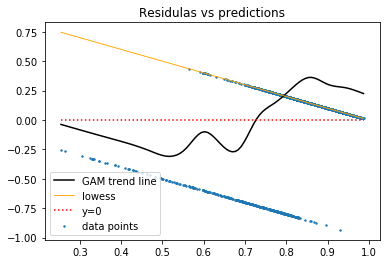

In [10]:
plot_residuals_correlation(forest, X_forest, y_forest, 'predictions')

Jak widzimy zmienna, którą chcemy przewidywać jest mocno niezbalansowana - zdecydowana większość obserwacji ma wartość 1. Widzimy, że również model zdecydowanie chętniej przewiduje wysokie wartości - praktycznie występują predykcje bliskie 0 i nawet wśród próbek, których wartość przewidywanej zmiennej to 0 zdaża się wiele predykcji z przedziału [0.5, 0.75]. Ten fakt potwierdzają również linie trendu lowess pokrywa się z predykcjami dla klasy 1, zaś GAM mocno odchyla się ku tej grupie, a nawet ją przekracza (nie potrafię tego wyjaśnić, mimo usilnych prób znalezienia błędu w kodzie).

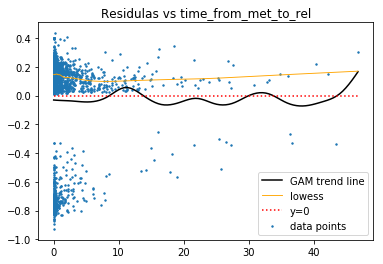

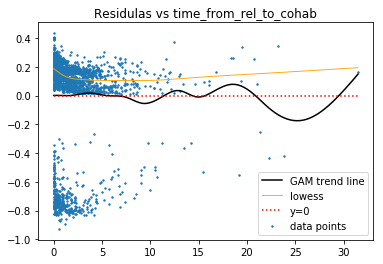

In [11]:
plot_residuals_correlation(forest, X_forest, y_forest, 'time_from_met_to_rel')
plot_residuals_correlation(forest, X_forest, y_forest, 'time_from_rel_to_cohab')

Z wykresu odczytujemy przede wszystkim fakt, że obie zmienne mają zdecydowaną większość wartości bliskich 0 i fakt iż większość próbek ma wartość przewidywanej klasy równą 1. Widzimy również, że krzywe trendu układają się wzdłuż y=0, ale są od niej różne (zwłaszcza lowess). Widzimy zatem, że obie zmienne wykazują tendencję do faworyzowania klasy 1.

In [28]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

def cooks_values(model, fresh_model, X, y):
    n, p = X.shape
    cooks_vals = []
    model_rss = mean_squared_error(y, model.predict(X)) * n
    for idx in tqdm_notebook(X.index):
        local_model = deepcopy(fresh_model)
        X_local, y_local = X.drop(idx, axis=0), y.drop(idx, axis=0)
        local_model.fit(X_local, y_local)
        rss_diff = mean_squared_error(model.predict_proba(X_local)[:, 1], local_model.predict_proba(X_local)[:, 1]) * (n - 1)
        cooks_val = rss_diff / (p * model_rss)
        cooks_vals.append(cooks_val)
    plt.scatter(range(n), cooks_vals, s=2)
    plt.show()
    return cooks_vals

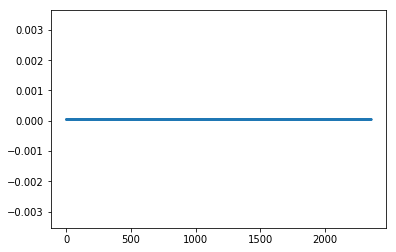

In [29]:
cv = cooks_values(forest, RandomForestClassifier(**
                                {'max_depth': 9,
                                 'max_features': 3,
                                 'min_samples_split': 2,
                                 'n_estimators': 500
                                },
                                n_jobs=-1), X_forest, y_forest)

In [40]:
X_forest['Cooks_distance'] = cv
X_forest.sort_values(by=['Cooks_distance']).head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,time_from_met_to_rel,time_from_rel_to_cohab,Q25_Different High School,Q25_Same High School,Q25_Refused,Q12_Leans Republican,Q12_Leans Democrat,Q12_Strong Democrat,Q12_Undecided/Independent/Other,Q12_Not Strong Democrat,Q12_Strong Republican,Q12_Not Strong Republican,Q12_Refused,Cooks_distance
1398,3.000000,4.250000,1,0,0,0,0,0,0,0,1,0,0,0.000043
2639,0.000000,0.666748,1,0,0,1,0,0,0,0,0,0,0,0.000043
996,0.000000,0.666626,1,0,0,0,0,0,1,0,0,0,0,0.000044
1779,1.833252,4.833374,0,1,0,1,0,0,0,0,0,0,0,0.000044
2403,0.000000,0.750000,1,0,0,0,1,0,0,0,0,0,0,0.000044


In [41]:
X_forest.sort_values(by=['Cooks_distance'], ascending=False).head()

,time_from_met_to_rel,time_from_rel_to_cohab,Q25_Different High School,Q25_Same High School,Q25_Refused,Q12_Leans Republican,Q12_Leans Democrat,Q12_Strong Democrat,Q12_Undecided/Independent/Other,Q12_Not Strong Democrat,Q12_Strong Republican,Q12_Not Strong Republican,Q12_Refused,Cooks_distance
2318,0.000000,0.583374,0,1,0,0,0,0,1,0,0,0,0,0.000067
564,4.666626,3.250000,0,1,0,0,0,0,0,1,0,0,0,0.000067
3264,0.000000,1.166626,1,0,0,0,0,0,1,0,0,0,0,0.000066
685,8.500000,0.000000,0,1,0,0,0,0,1,0,0,0,0,0.000066
1159,2.000000,0.000000,1,0,0,0,0,1,0,0,0,0,0,0.000066


Jak widzimy, wszystkie wartości Cooka znajdują leżą w przedziale [0.000043, 0.000067], czyli wszystkie są bardzo małe. Oznacza to, że nie pojedyncza obserwacja nie ma prawie żadnego wpływu na model, czyli model jest stabilny. Zgadza się to ze wcześniejszymi obserwacjami iż model prawie zawsze zwraca wartość 1, więc faktycznie spodziewaliśmy się, że pojedyncza obserwacja nie zmieni tego w znaczym stopniu.